# Parameter estimation with `parmest`

Created by [Kanishka Ghosh](https://github.com/kanishka-ghosh), [Jialu Wang](https://github.com/jialuw96), and [Prof. Alex Dowling](https://github.com/adowling2/) at the University of Notre Dame. Updated for module deprecation by Stephen Cini (scini@nd.edu, 2024).

In [1]:
# This code cell installs packages on Colab
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.install_idaes()
    helper.install_ipopt()
    # helper.download_data(['parmest_20210609_data_exp{:d}.csv'.format(i) for i in range(1,17)])
    # helper.download_data(['parmest_log_file.csv'])
    # !pyomo build-extensions

--2024-12-14 03:26:41--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py.15’

helper.py.15        100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-12-14 03:26:42 (50.1 MB/s) - ‘helper.py.15’ saved [6493/6493]

idaes was found! No need to install.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.environ as pyo
import pyomo.dae as dae
import pyomo
# Define the directory to save/read the data files
data_dir = 'https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/data/'


## What is parameter estimation?

Given a function $f(x,\theta)$ where $x$ is the input or array of inputs, $\theta$ is the vector of unknown model parameters, and $y$ is the array of observed output, parameter estimation is performed to determine the values of $\theta$ to minimize the error between $f(x,\theta)$ and $y$.  Commonly, parameter estimation is set up as a least squares objective problem:

$$
\begin{align}
\begin{split}
    \min_{\hat{\theta}} \quad & \sum_{i}^{} (y_i - f(x_i,\hat{\theta}))^2\\
    \textrm{s.t.} \quad & \mathrm{bounds \ on} \ \theta\\
    & \mathrm{other \ physical \ constraints}\\
\end{split}
\end{align}
$$

where $i$ is used to index the datapoints in a dataset and $\hat{\theta}$ is the optimal set of parameter values that minimizes the prediction error.

## What is `parmest`?

`parmest` is a Python package built on the [Pyomo optimization modeling language](http://www.pyomo.org/) to support parameter estimation using experimental data along with confidence regions and subsequent creation of scenarios for [PySP](https://github.com/Pyomo/pysp). `parmest` supports scenario generation for multiple 'experiments' and can be used to characterize estimate uncertainties through, for example, confidence region generations. `parmest` requires the following positional arguments in order solve the optimization problem:
1. Function that accepts an 'experimental' dataset or a list of 'experimental' datasets, each defined as a dictionary, as it's argument and returns the Pyomo model.
    
    Later in this tutorial, that function is defined above as `create_model()`


2. List of datasets where each dataset is a dictionary

    Later in this tutorial, the list of datasets is generated using the function `create_data_dict()` (defined below) and is stored in `data_dict_overall`


3. List of parameter names (as they appear in the Pyomo model definition) that are being estimated

    later in this tutorial, the list of parameter names to be estimated is defined below by `theta_names`


4. Optional keyword argument to define the verbosity of solver output.  Default: False

More information about the `parmest` package can be found [here](https://pyomo.readthedocs.io/en/stable/contributed_packages/parmest/index.html).

Detailed explanation of the various methods in `parmest` can be found [here](https://www.osti.gov/servlets/purl/1761797).


## Example: Reaction Kinetics

Consider two chemical reactions that convert molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$$

Our ultimate goals is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$$r_A = -k_1 C_A$$

$$r_B = k_1 C_A - k_2 C_B$$

$$r_C = k_2 C_B$$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$$k_1 = A_1 \exp{\frac{-E_1}{R T}}$$

$$k_2 = A_2 \exp{\frac{-E_2}{R T}}$$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

### Batch Reactor

The concentrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e.,

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

The following Python code simulates and plots this model.

In [28]:
def kinetics(A, E, T):
    ''' Computes kinetics from Arrhenius equation

    Arguments:
        A: pre-exponential factor, [1 / hr]
        E: activation energy, [kJ / mol]
        T: temperature, [K]

    Returns:
        k: reaction rate coefficient, [1 / hr]

    '''
    R = 8.31446261815324 # J / K / mole

    return A * np.exp(-E*1000/(R*T))

def concentrations(t,k,CA0):
    '''
    Returns concentrations at time t

    Arguments:
        t: time, [hr]
        k: reaction rate coefficient, [1 / hr]
        CA0: initial concentration of A, [mol / L]

    Returns:
        CA, CB, CC: concentrations of A, B, and C at time t, [mol / L]
    '''
    CA = CA0 * np.exp(-k[0]*t);
    CB = k[0]*CA0/(k[1]-k[0]) * (np.exp(-k[0]*t) - np.exp(-k[1]*t));
    CC = CA0 - CA - CB;

    return CA, CB, CC

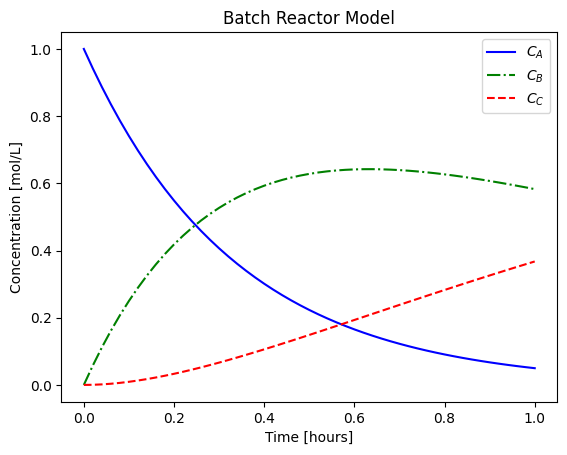

In [4]:
CA0 = 1 # Moles/L
k = [3, 0.7] # 1/hr

t = np.linspace(0,1,51)
CA, CB, CC = concentrations(t,k,CA0)
plt.plot(t, CA, label="$C_{A}$",linestyle="-",color="blue")
plt.plot(t, CB, label="$C_{B}$",linestyle="-.",color="green")
plt.plot(t, CC, label="$C_{C}$",linestyle="--",color="red")
plt.xlabel("Time [hours]")
plt.ylabel("Concentration [mol/L]")
plt.title("Batch Reactor Model")
plt.legend()
plt.show()
plt.close()

### Experimental Data

See the notebook *Supplementary material: data for parmest tutorial* for details on how these experimental data were generated (via simulation).

Experimental data consists of the concentration of species A, B, and C in $\mathrm{mol/L}$ with respect to time $t$ in $\mathrm{hours}$ inside the batch reactor. The experimental data is stored in csv files where the first column records the time $t$ in the reactor. Next, the temperature $T$ in $\mathrm{K}$ at which the reaction was simulated is recorded followed by the initial concentration of species A, $C_{A,0}$, in $\mathrm{mol/L}$. Finally, the time-varying species concentrations ($C_A$), ($C_B$), and ($C_C$) are recorded in $\mathrm{mol/L}$. Following is how the pandas dataframe of a single experiment looks like:

In [5]:
# define function to plot
def plot_exp(k, CA0, data, text):
    '''
    Plot concentration profiles
    Arguments:
        k: kinetic parameters
        CA0: initial concentration
        data: Pandas data frame
        text: plot title

    '''
    # evaluate models
    t = np.linspace(0,1,51)
    CA, CB, CC = concentrations(t,k,CA0)

    # plot model-generated and 'experimental' data
    # symbols for 'experimental' data
    # solid and dashed lines for model-generated data
    plt.plot(t, CA,label="$C_{A}$",linestyle="-",color="blue")
    plt.plot(data.time, data.CA, marker='o',linestyle="",color="blue",label=str())
    plt.plot(t, CB, label="$C_{B}$",linestyle="-.",color="green")
    plt.plot(data.time, data.CB, marker='s',linestyle="",color="green",label=str())
    plt.plot(t, CC, label="$C_{C}$",linestyle="--",color="red")
    plt.plot(data.time, data.CC, marker='^',linestyle="",color="red",label=str())
    plt.xlabel("Time [hours]")
    plt.ylabel("Concentration [mol/L]")
    plt.title(text)
    plt.legend()
    plt.show()
    plt.close()

### Pyomo model

In the following cell, we define a function to define and return the Pyomo model for the kinetic model to be used for parameter estimation.

### Non DAE version

In [32]:
import pyomo.contrib.parmest.parmest as parmest
from pyomo.contrib.parmest.experiment import Experiment

def reaction_kinetics_model():

    # define Pyomo model
    m = pyo.ConcreteModel()
    # m.T = data['T'] # K
    # m.CA0 = data['CA0'] # mol/L

    # # define 'experimental' data timesteps as Pyomo set
    m.t = pyo.Set(bounds = (0,1))

    # # define 'experimental' data as Pyomo parameters indexed by timestep set and
    # # initialized by dictionary of experimental data
    # m.Ca_meas = pyo.Param(m.t, initialize=cameas)
    # m.Cb_meas = pyo.Param(m.t, initialize=cbmeas)
    # m.Cc_meas = pyo.Param(m.t, initialize=ccmeas)

    m.CA0 = 1
    m.R = 8.31446261815324 # J / K / mole
    m.T = 250 # K

    # Kinetic parameters to be fitted defined as Pyomo variables
    # Initialized by 'true' values
    m.A1 = pyo.Var(initialize=200, bounds=(100,300)) # 1/hr
    m.A2 = pyo.Var(initialize=400, bounds=(300,500)) # 1/hr
    m.E1 = pyo.Var(initialize=10, bounds=(1,20)) # kJ/mol
    m.E2 = pyo.Var(initialize=15, bounds=(1,30)) # kJ/mol

    # Concentration variables indexed by time
    m.CA = pyo.Var(m.t, initialize = m.CA0) # mol/L
    m.CB = pyo.Var(m.t, initialize = 0) # mol/L
    m.CC = pyo.Var(m.t, initialize = 0) # mol/L


    # kinetic rate constants from Arrhenius equation
    m.k1 = pyo.Expression(rule = m.A1 * pyo.exp(-m.E1*1000/(m.R*m.T))) # 1/hr
    m.k2 = pyo.Expression(rule = m.A2 * pyo.exp(-m.E2*1000/(m.R*m.T))) # 1/hr

    # Constraints to change concentrations based on kinetics
    def conc_A(m,i):
            return m.CA[i] == m.CA0 * pyo.exp(-m.k1*i)
    m.CA_rate = pyo.Constraint(m.t,rule=conc_A)

    def conc_B(m,i):
            return m.CB[i] == m.k1*m.CA0/(m.k2-m.k1) * (pyo.exp(-m.k1*i) - pyo.exp(-m.k2*i))
    m.CB_rate = pyo.Constraint(m.t,rule=conc_B)

    def conc_C(m,i):
            return m.CC[i] == m.CA0 - m.CA[i] - m.CB[i]
    m.CC_rate = pyo.Constraint(m.t,rule=conc_C)


    # Fix initial conditions in OG model
    m.A1.fix(200) # 1/hr
    m.A2.fix(400) # 1/hr
    m.E1.fix(10) # kJ/mol
    m.E2.fix(15) # kJ/mol

    m.CA[0].fix(m.CA0)
    m.CB[0].fix(0.0)
    m.CC[0].fix(0.0)

    return m

class ReactionKineticsExperiment(Experiment):

    def __init__(self, data): # , experiment_number):
        self.data = data
        # self.experiment_number = experiment_number
        # self.data_i = data.loc[experiment_number, :]
        self.model = None

    def create_model(self):
        self.model = m = reaction_kinetics_model()
        return m

    def finalize_model(self):
        m = self.model

        m.t.update(self.data['time'])

        # Initial Conditions

        m.CA0 = self.data['CA0'][0]
        m.T = self.data['T'][0]

        m.CA[0].fix(m.CA0)
        m.CB[0].fix(0.0)
        m.CC[0].fix(0.0)

        m.A1.fix(200) # 1/hr
        m.A2.fix(400) # 1/hr
        m.E1.fix(10) # kJ/mol
        m.E2.fix(15) # kJ/mol


        return m

    def label_model(self):
        m = self.model

        m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_outputs.update(
            (m.CA[t], self.data['CA'][ind]) for ind, t in enumerate(self.data['time']))
        m.experiment_outputs.update(
                (m.CB[t], self.data['CB'][ind]) for ind, t in enumerate(self.data['time']))
        m.experiment_outputs.update(
                (m.CC[t], self.data['CC'][ind]) for ind, t in enumerate(self.data['time']))

        m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.unknown_parameters.update(
            (k, pyo.ComponentUID(k)) for k in [m.A1, m.A2, m.E1, m.E2]
        )

        return m

    def get_labeled_model(self):
        m = self.create_model()
        m = self.finalize_model()
        m = self.label_model()
        # m.pprint()

        return m


In [31]:
# Test model

m = reaction_kinetics_model()

# # discretize model
# disc = pyo.TransformationFactory('dae.collocation')
# disc.apply_to(m, wrt=m.t, scheme='LAGRANGE-RADAU')

# solve model

solver = pyo.SolverFactory('ipopt')

# solve model
solver.solve(m,tee=True)
# m.pprint()

# plot results
CA = [pyo.value(m.CA[i]) for i in m.t]
CB = [pyo.value(m.CB[i]) for i in m.t]
CC = [pyo.value(m.CC[i]) for i in m.t]
plt.plot(m.t, CA, label="$C_{A}$",linestyle="-",color="blue")
plt.plot(m.t, CB, label="$C_{B}$",linestyle="-.",color="green")
plt.plot(m.t, CC, label="$C_{C}$",linestyle="--",color="red")
plt.xlabel("Time [hours]")
plt.ylabel("Concentration [mol/L]")
plt.title("Batch Reactor Model")
plt.legend()

KeyError: "Index '0' is not valid for indexed component 'CA'"

## Parameter estimation with a single dataset

Here, we will estimate parameters $A_1$, $A_2$, $E_1$, and $E_2$ using data generated for a batch 'experiment' at 250 C with an inlet concentration of 0.5 mol/L of A.

The parameter estimation problem is solved with the least squares optimization scheme

The parameter estimation problem is solved with the least squares optimization scheme
$$
\begin{align}
\begin{split}
    \min_{\hat{\theta}} \quad & \sum_{i}^{} (y_i - f(x_i,\hat{\theta}))^2\\
    \textrm{s.t.} \quad & \mathrm{bounds \ on} \ \theta\\
    & \mathrm{other \ physical \ constraints}\\
\end{split}
\end{align}
$$
where $i$ is used to index the datapoints in a dataset and $\hat{\theta}$ is the optimal set of parameter values that minimizes the prediction error.


In [8]:
# # read-in data from csv file

data = pd.read_csv('https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/data/parmest_20210609_data_exp1.csv',index_col=0)

# # run parmest

exp_list = []
df = data

exp_list.append(ReactionKineticsExperiment(df))

pest = parmest.Estimator(exp_list, obj_function='SSE')

obj, theta = pest.theta_est()

print(theta)

#model = pest.ef_instance
model = pest.ef_instance

print("===  Parameter values  ===")
print("A1 = {:0.3f} 1/hr".format(pyo.value(model.A1)))
print("A2 = {:0.3f} 1/hr".format(pyo.value(model.A2)))
print("E1 = {:0.3f} kJ/mol".format(pyo.value(model.E1)))
print("E2 = {:0.3f} kJ/mol".format(pyo.value(model.E2)))

  - termination condition: infeasible
  - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible point. Problem may be infeasible.


E1      9.840376
A2    400.726910
E2     12.666011
A1    200.760361
dtype: float64
===  Parameter values  ===
A1 = 200.760 1/hr
A2 = 400.727 1/hr
E1 = 9.840 kJ/mol
E2 = 12.666 kJ/mol


## Parameter estimation with multiple datasets

Here, we will estimate parameters $A_1$, $A_2$, $E_1$, and $E_2$ using data generated for a batch 'experiment' at 250 C with an inlet concentration of 0.5 mol/L of A.

The parameter estimation problem is now defined to solve optimization problem where the objective function is the mean of the least square error between observed and calculated data for multiple experiments.

$$
\begin{align}
\begin{split}
    \min_{\hat{\theta}} \quad & \frac{1}{N}\sum_{j}^{}\sum_{i}^{} (y_{j,i} - f(x_{j,i},\hat{\theta}))^2\\
    \textrm{s.t.} \quad & \mathrm{bounds \ on} \ \theta\\
    & \mathrm{other \ physical \ constraints}\\
\end{split}
\end{align}
$$

where $i$ is used to index the datapoints in a dataset, $j$ is an index on the dataset such that $j \in [1,N]$ and $N$ is the number of experiments conducted.

### Generate list of dataset

In the following cell, we define a function to generate a list of dictionaries containing the 'experimental' data.  For this, we read-in the list of file names generated earlier

### Parameter estimation with parmest

In the following cell, we perform parameter estimation using parmest to solve the least squares problem defined in the Pyomo model.

In [9]:
# # read-in data from csv file

data = pd.read_csv('https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/data/parmest_20210609_data_exp1.csv',index_col=0)

# # run parmest

exp_list = []
file_name_generic = 'https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/data/parmest_20210609_data_exp{}.csv'

for i in range(16): #making a list of different experiments, each exp has corresponding data
  df = pd.read_csv(file_name_generic.format(i+1),index_col=0)
  # print(df.head())
  exp_list.append(ReactionKineticsExperiment(df))

pest = parmest.Estimator(exp_list, obj_function='SSE')

obj, theta = pest.theta_est()

print(theta)

#model = pest.ef_instance
model = pest.ef_instance.Scenario0

print("===  Parameter values  ===")
print("A1 = {:0.3f} 1/hr".format(pyo.value(model.A1)))
print("A2 = {:0.3f} 1/hr".format(pyo.value(model.A2)))
print("E1 = {:0.3f} kJ/mol".format(pyo.value(model.E1)))
print("E2 = {:0.3f} kJ/mol".format(pyo.value(model.E2)))

  - termination condition: infeasible
  - message from solver: Ipopt 3.13.2\x3a Converged to a locally infeasible point. Problem may be infeasible.


E1      8.444988
A2    401.173325
E2     11.164003
A1    202.451169
dtype: float64
===  Parameter values  ===
A1 = 202.451 1/hr
A2 = 401.173 1/hr
E1 = 8.445 kJ/mol
E2 = 11.164 kJ/mol


### Plotting fitted model simulation with 'experimental' data

Next, we plot the 'experimental' data along with the profiles generated using the fitted kinetic model.  The symbols represent the 'experimental' data and the solid and dashed lines are the profiles generated using the fitted model.

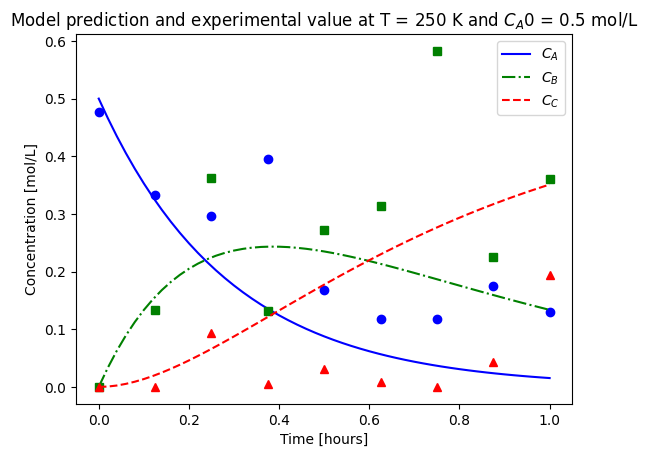

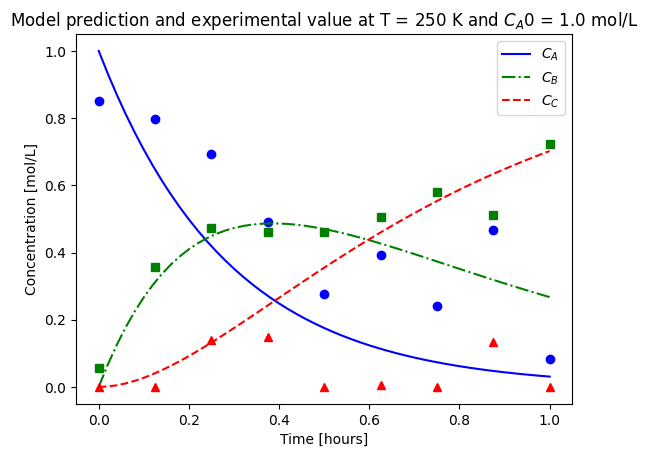

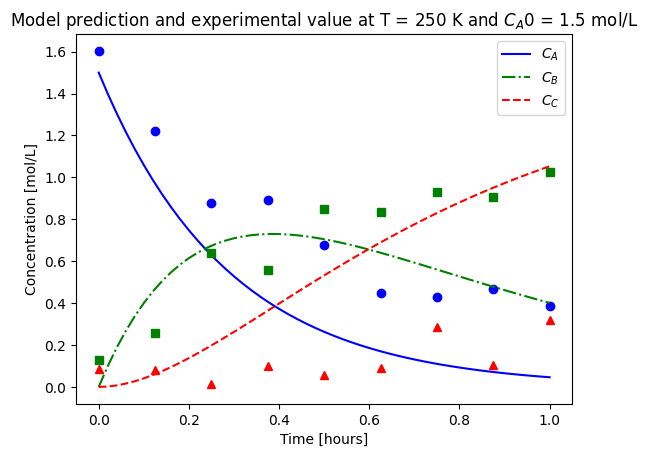

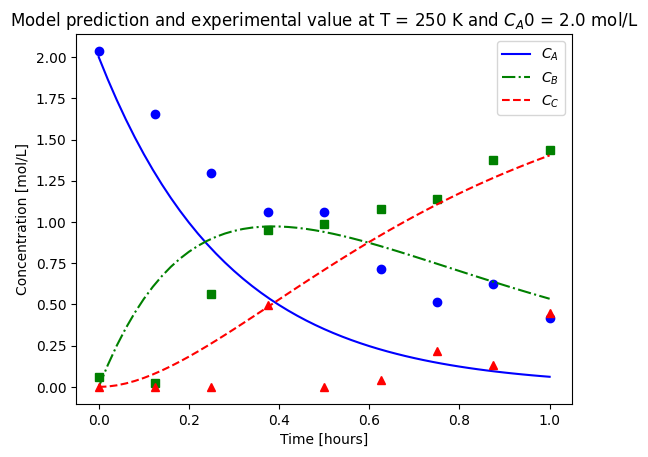

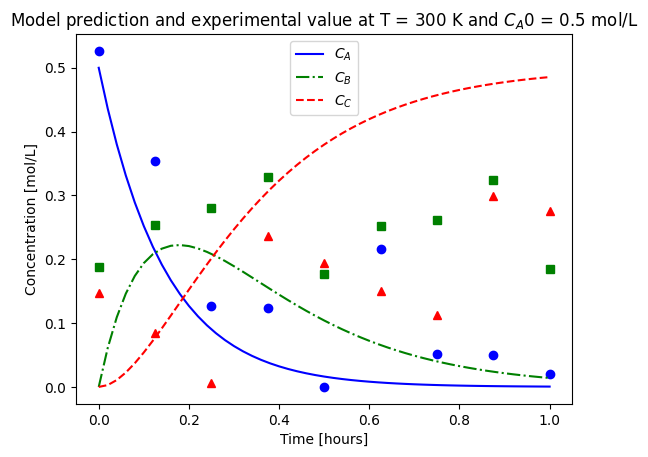

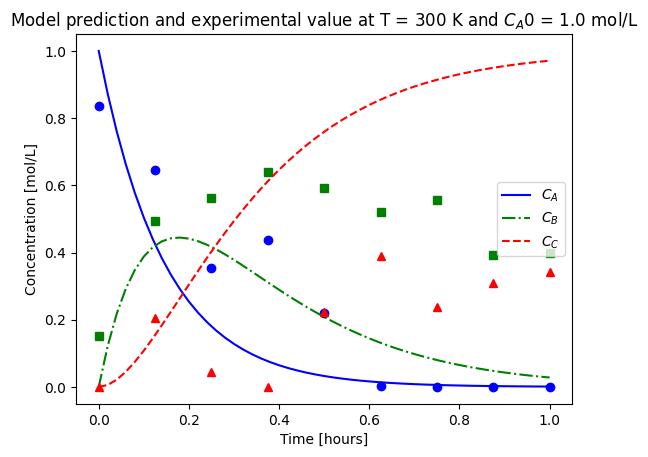

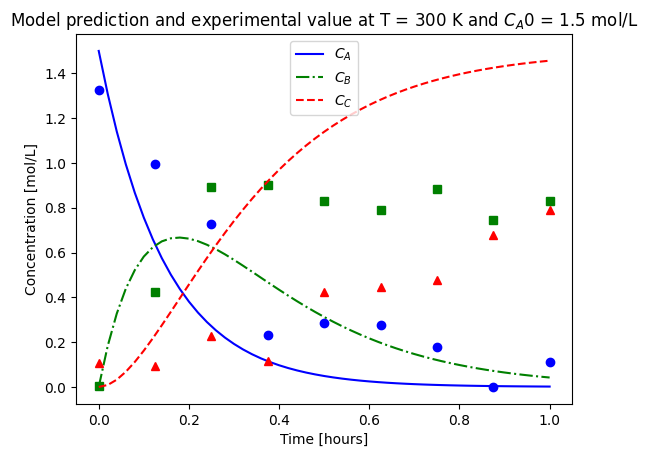

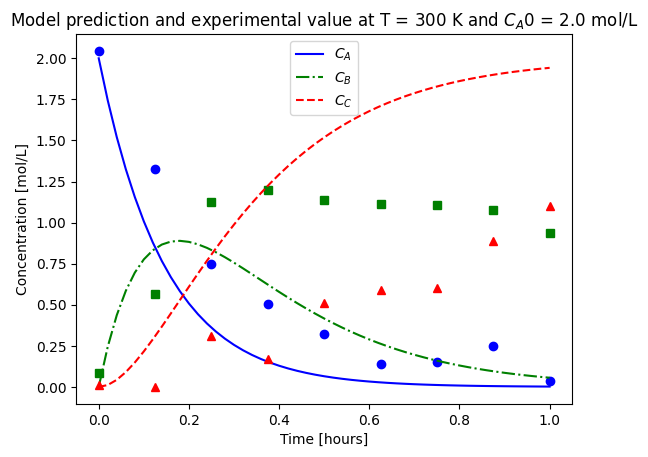

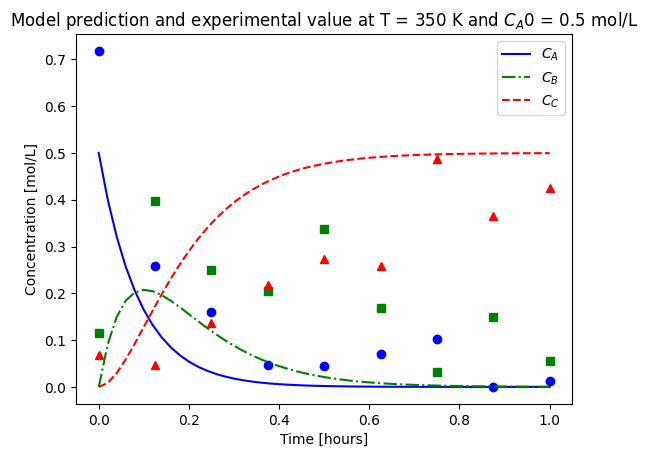

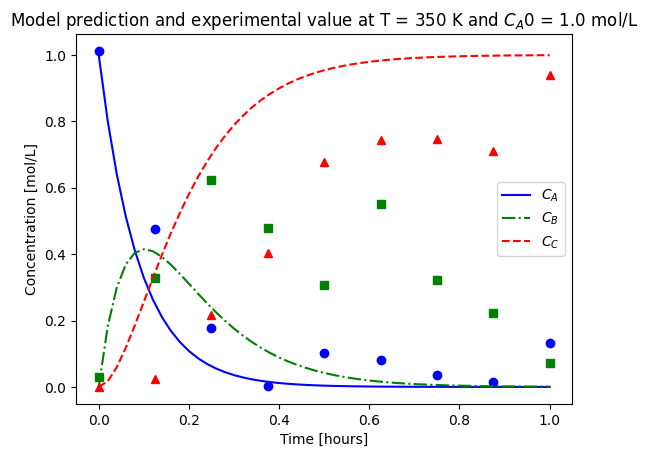

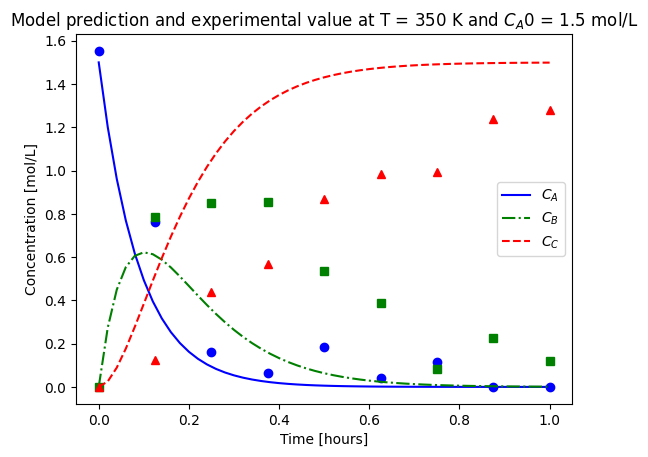

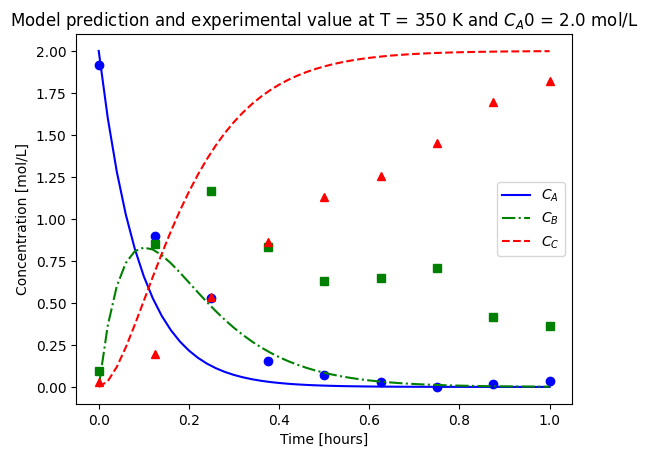

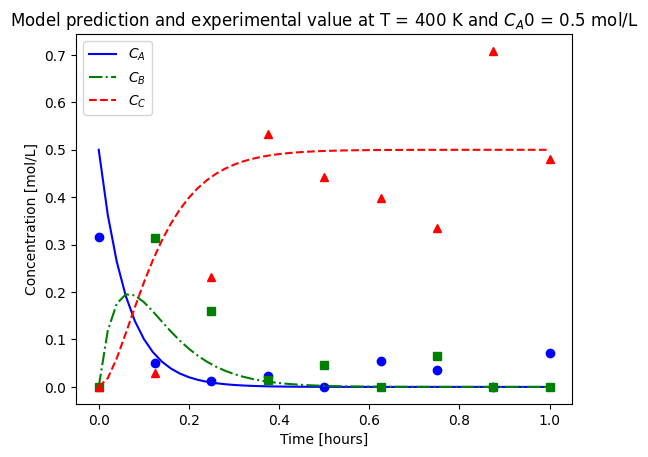

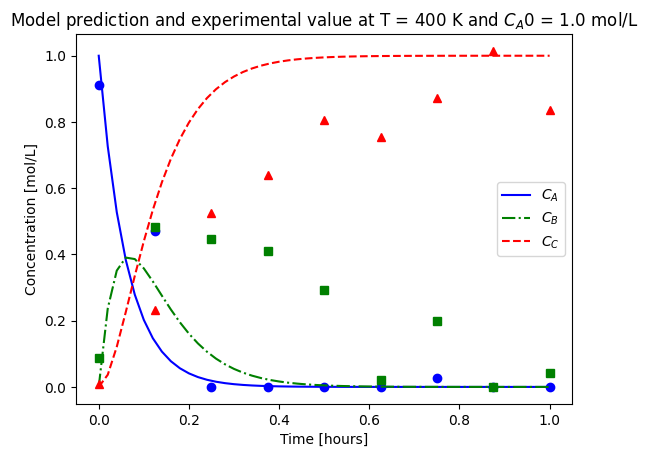

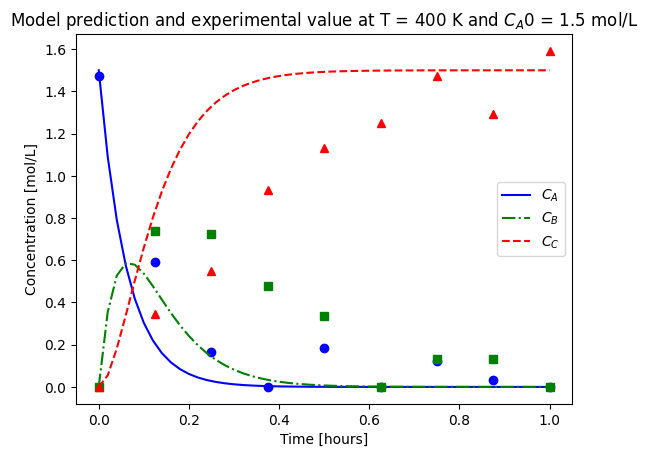

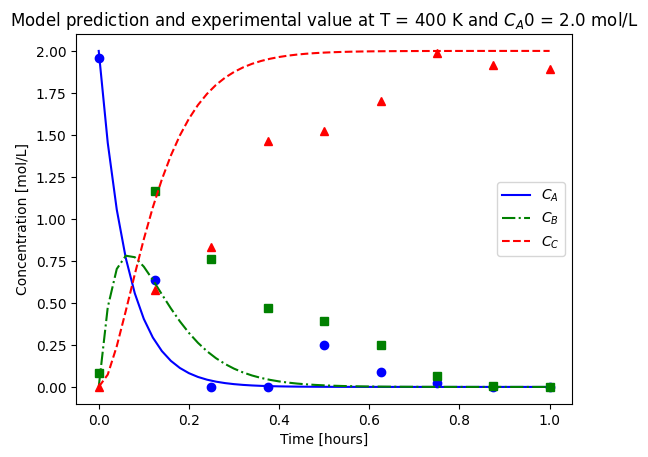

In [10]:
# list of temperatures
T_vals = [250,300,350,400] # K

# list of initial concentrations of A
CA0_vals = [0.5,1.0,1.5,2.0] # mol/L

# Parameter values from parameter estimation using parmest
A1 = theta['A1']
E1 = theta['E1']
A2 = theta['A2']
E2 = theta['E2']


A_est1 = [A1, A2]
A_est = np.asarray(A_est1)

E_est1 = [E1, E2]
E_est = np.asarray(E_est1)

ctr = 0
for T in T_vals:
    for CA0 in CA0_vals:
        # generate concentration profiles using estimated parameter values
        k = kinetics(A_est, E_est, T)
        # plot model-generated and 'experimental' data
        # symbols for 'experimental' data
        # solid and dashed lines for model-generated data
        df = pd.read_csv(file_name_generic.format(ctr+1),index_col=0)
        plot_exp(k, CA0, df, 'Model prediction and experimental value at T = {} K and $C_{}$ = {} mol/L'.format(T,'A0',CA0))
        ctr+=1

## Using `parmest` with `pyomo.dae`

In contrast to the approach above, we will now try to solve the model without the analytic solution for the concentrations using Pyomo.DAE.  To recap, the concentrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e.,

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

In the following cell, we define a function to define and return the Pyomo DAE model (dynamic mode) for the kinetic model to be used for parameter estimation.  In this model, the rate equations are presented in terms of linear differential equations.

In [11]:
import pyomo.contrib.parmest.parmest as parmest
from pyomo.contrib.parmest.experiment import Experiment

def reaction_kinetics_model_dae():

    # define Pyomo model
    m = pyo.ConcreteModel()
    # m.T = data['T'] # K
    # m.CA0 = data['CA0'] # mol/L

    # # define 'experimental' data timesteps as Pyomo set
    m.t = dae.ContinuousSet(bounds = (0,1))

    # # define 'experimental' data as Pyomo parameters indexed by timestep set and
    # # initialized by dictionary of experimental data
    # m.Ca_meas = pyo.Param(m.t, initialize=cameas)
    # m.Cb_meas = pyo.Param(m.t, initialize=cbmeas)
    # m.Cc_meas = pyo.Param(m.t, initialize=ccmeas)

    m.CA0 = 1
    m.R = 8.31446261815324 # J / K / mole
    m.T = 250 # K

    # Kinetic parameters to be fitted defined as Pyomo variables
    # Initialized by 'true' values
    m.A1 = pyo.Var(initialize=200, bounds=(100,300)) # 1/hr
    m.A2 = pyo.Var(initialize=400, bounds=(300,500)) # 1/hr
    m.E1 = pyo.Var(initialize=10, bounds=(1,20)) # kJ/mol
    m.E2 = pyo.Var(initialize=15, bounds=(1,30)) # kJ/mol

    # Concentration variables indexed by time
    m.CA = pyo.Var(m.t, initialize = m.CA0) # mol/L
    m.CB = pyo.Var(m.t, initialize = 0) # mol/L
    m.CC = pyo.Var(m.t, initialize = 0) # mol/L

    # Derivatives of concentration
    m.dCA = dae.DerivativeVar(m.CA, wrt = m.t)
    m.dCB = dae.DerivativeVar(m.CB, wrt = m.t)
    m.dCC = dae.DerivativeVar(m.CC, wrt = m.t)

    # kinetic rate constants from Arrhenius equation
    m.k1 = pyo.Expression(rule = m.A1 * pyo.exp(-m.E1*1000/(m.R*m.T))) # 1/hr
    m.k2 = pyo.Expression(rule = m.A2 * pyo.exp(-m.E2*1000/(m.R*m.T))) # 1/hr

    # Constraints to change concentrations based on kinetics
    def conc_A(m,i):
        return m.dCA[i] == - m.k1 * m.CA[i]
    m.CA_rate = pyo.Constraint(m.t,rule=conc_A)

    def conc_B(m,i):
        return m.dCB[i] == m.k1 * m.CA[i] - m.k2 * m.CB[i]
    m.CB_rate = pyo.Constraint(m.t,rule=conc_B)

    def conc_C(m,i):
        return m.dCC[i] == m.k2 * m.CB[i]
    m.CC_rate = pyo.Constraint(m.t,rule=conc_C)


    # init cond
    m.CA[0].fix(m.CA0)
    m.CB[0].fix(0.0)
    m.CC[0].fix(0.0)

    m.A1.fix(200) # 1/hr
    m.A2.fix(400) # 1/hr
    m.E1.fix(10) # kJ/mol
    m.E2.fix(15) # kJ/mol
    return m

class ReactionKineticsExperiment_dae(Experiment):

    def __init__(self, data, experiment_number=0):
        self.data = data
        self.experiment_number = experiment_number
        # self.data_i = data[experiment_number, :]
        self.model = None

    def create_model(self):
        self.model = m = reaction_kinetics_model_dae()
        return m

    def finalize_model(self):
        m = self.model
        m.t.update(self.data['time'])

        # Discretize model

        m.CA0 = self.data['CA0'][0]
        m.T = self.data['T'][0]

        m.CA[0].fix(m.CA0)
        m.CB[0].fix(0.0)
        m.CC[0].fix(0.0)

        m.A1.fix(200) # 1/hr
        m.A2.fix(400) # 1/hr
        m.E1.fix(10) # kJ/mol
        m.E2.fix(15) # kJ/mol


        discretizer = pyo.TransformationFactory('dae.collocation')
        discretizer.apply_to(m, wrt=m.t, nfe = 20, ncp = 4, scheme='LAGRANGE-RADAU')

        # Initial Conditions




        return m

    def label_model(self):
        m = self.model

        # m.experiment_inputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        # m.experiment_inputs.update(
        #     [
        #         # (m.T, self.data_i['T']),
        #         # (m.CA0, self.data_i['CA0']),

        #         (m.T, self.data['T'][0]),
        #         (m.CA0, self.data['CA0'][0]),
        #     ]
        # )

        m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_outputs.update(
            (m.CA[t], self.data['CA'][ind]) for ind, t in enumerate(self.data['time']))
        m.experiment_outputs.update(
                (m.CB[t], self.data['CB'][ind]) for ind, t in enumerate(self.data['time']))
        m.experiment_outputs.update(
                (m.CC[t], self.data['CC'][ind]) for ind, t in enumerate(self.data['time']))


        m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.unknown_parameters.update(
            (k, pyo.ComponentUID(k)) for k in [m.A1, m.A2, m.E1, m.E2]
        )

        return m

    def get_labeled_model(self):
        m = self.create_model()
        # m.pprint()
        m = self.finalize_model()
        m = self.label_model()

        return m


### Parameter estimation with parmest

In the following cell, we perform parameter estimation using parmest to solve the least squares problem defined in the Pyomo dynamic model.

In [33]:
# list of temperatures
T_vals = [250,300,350,400] # K

# list of initial concentrations of A
CA0_vals = [0.5,1.0,1.5,2.0] # mol/L

# run parmest

exp_list = []
file_name_generic = 'https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/data/parmest_20210609_data_exp{}.csv'

for i in range(16): #making a list of different experiments, each exp has corresponding data
  df = pd.read_csv(file_name_generic.format(i+1),index_col=0)
  # print(df.head())
  exp_list.append(ReactionKineticsExperiment_dae(df))

pest = parmest.Estimator(exp_list, obj_function='SSE')

obj, theta = pest.theta_est()

# print(theta)

#model = pest.ef_instance
model = pest.ef_instance.Scenario0

print("===  Parameter values  ===")
print("A1 = {:0.3f} 1/hr".format(pyo.value(model.A1)))
print("A2 = {:0.3f} 1/hr".format(pyo.value(model.A2)))
print("E1 = {:0.3f} kJ/mol".format(pyo.value(model.E1)))
print("E2 = {:0.3f} kJ/mol".format(pyo.value(model.E2)))

===  Parameter values  ===
A1 = 202.635 1/hr
A2 = 401.161 1/hr
E1 = 8.320 kJ/mol
E2 = 11.199 kJ/mol


### Plotting fitted model simulation with 'experimental' data

Next, we plot the 'experimental' data along with the profiles generated using the fitted kinetic model.  The symbols represent the 'experimental' data and the solid and dashed lines are the profiles generated using the fitted model.

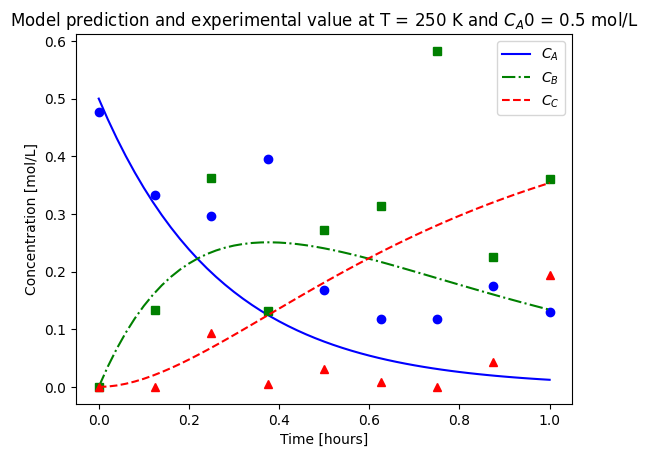

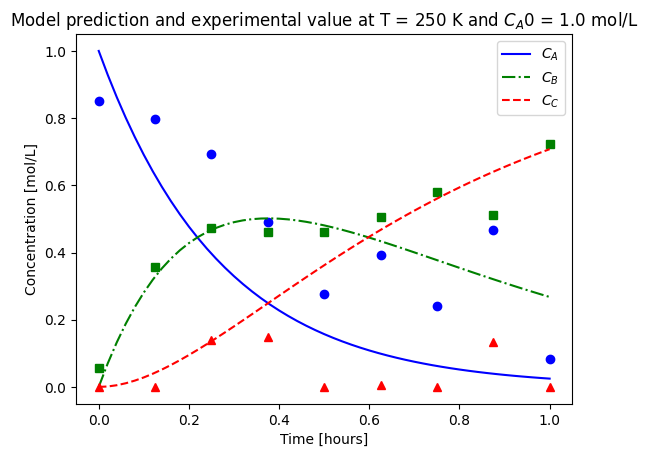

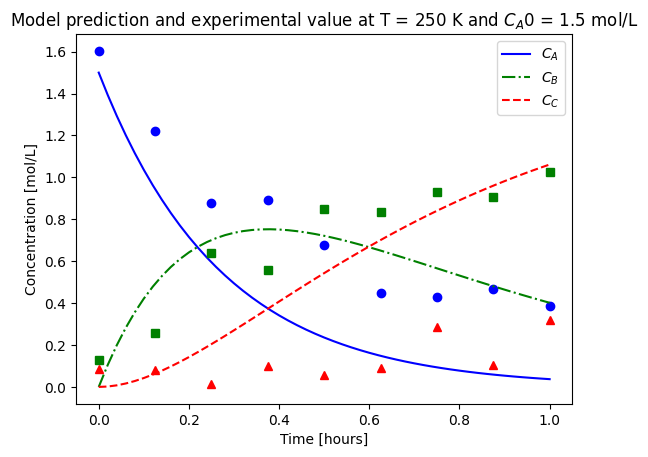

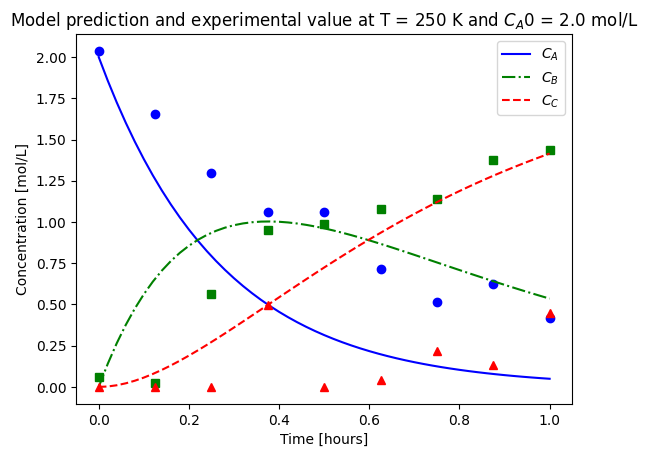

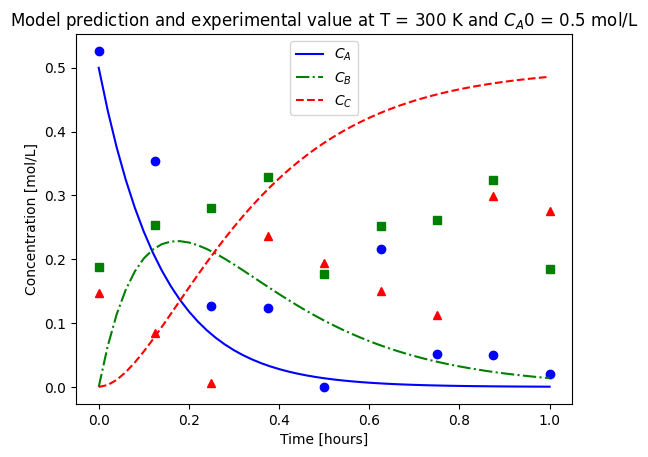

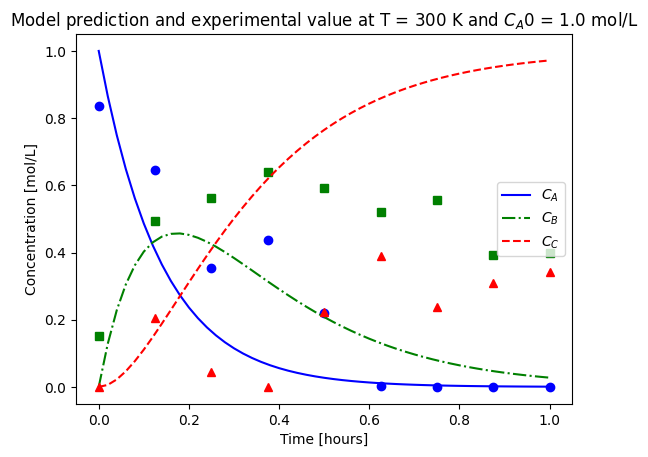

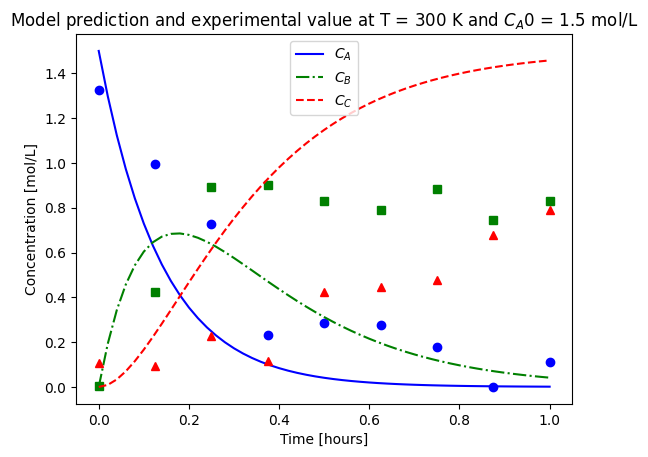

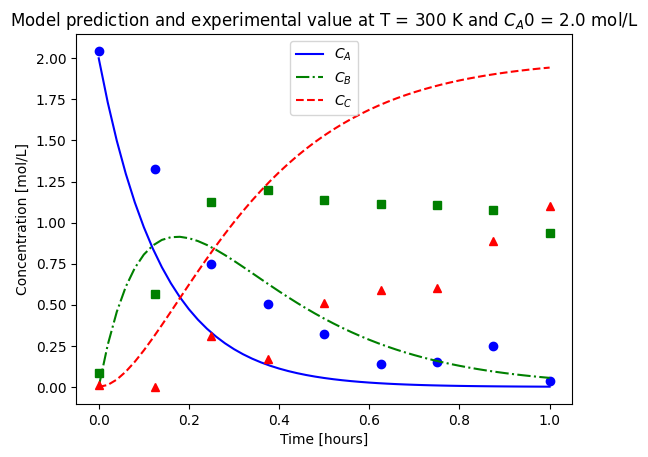

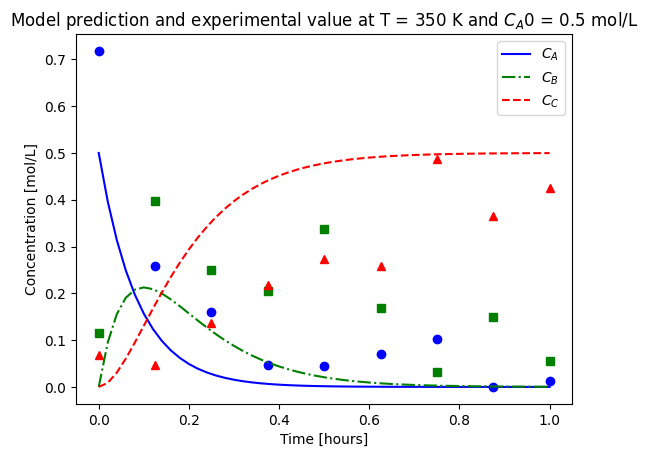

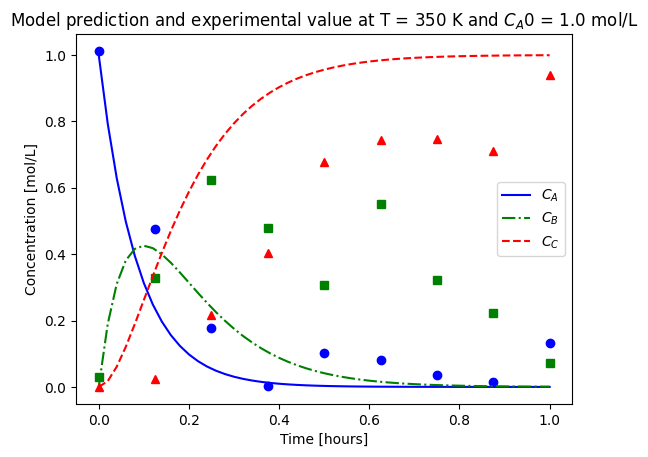

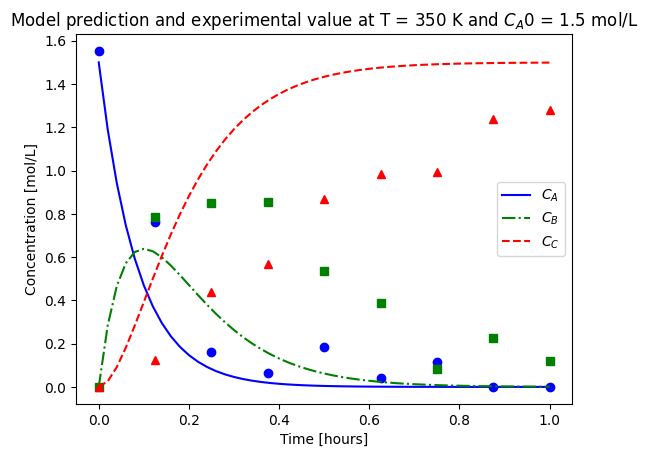

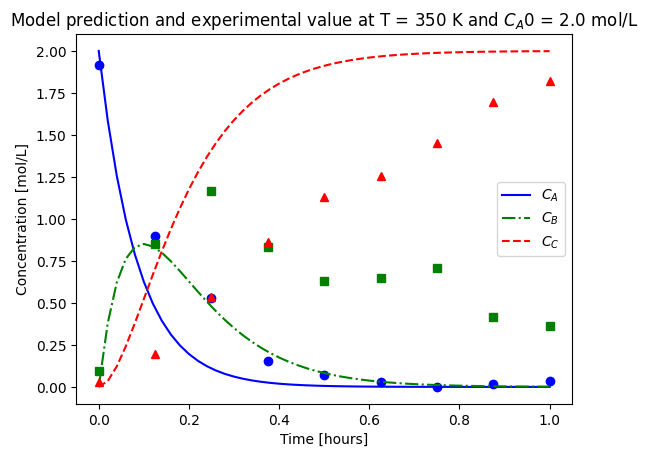

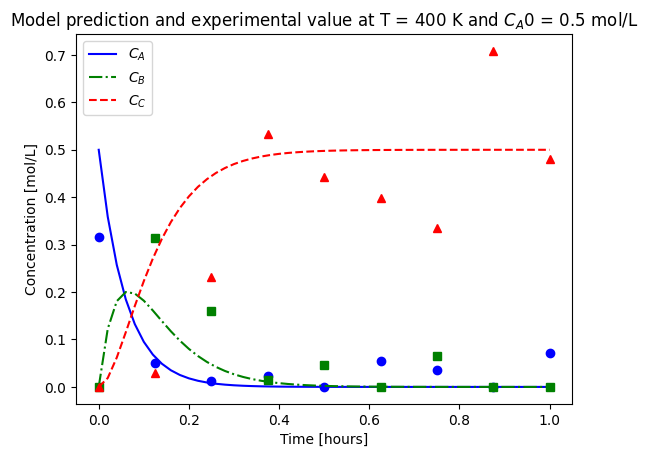

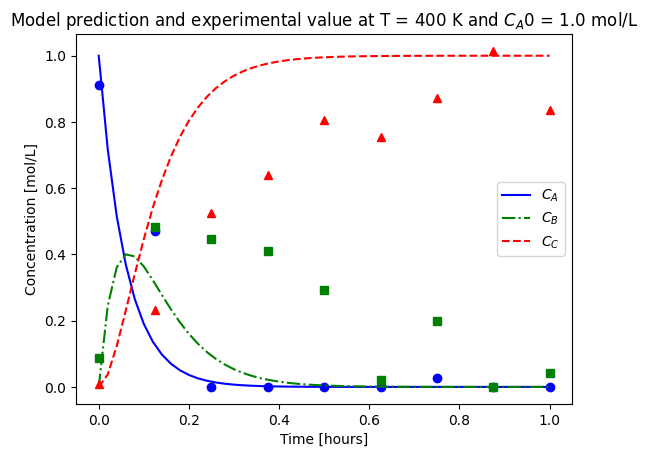

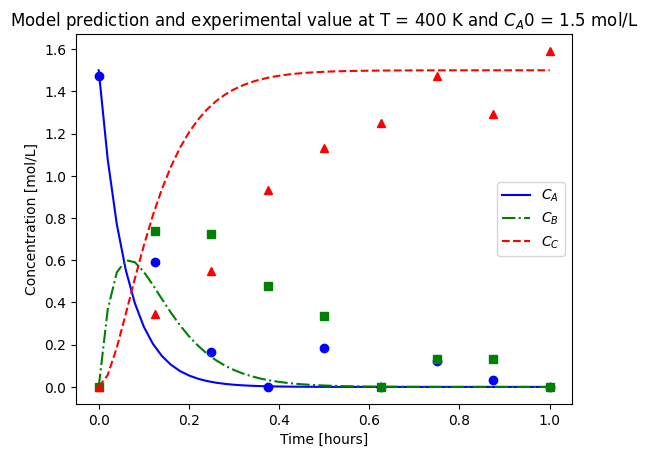

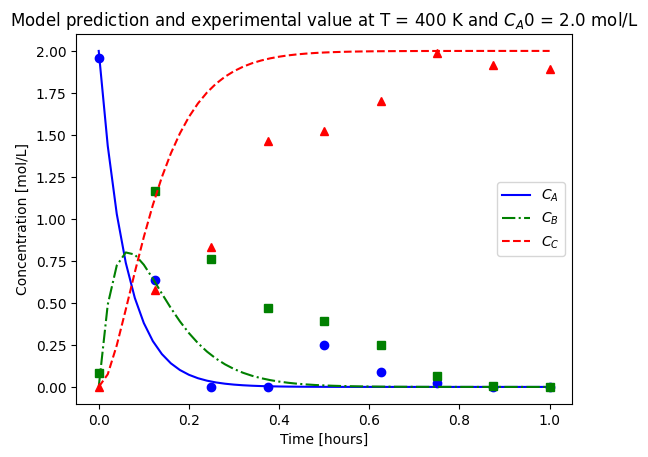

In [13]:
# Parameter values from parameter estimation using parmest
A1 = theta['A1']
E1 = theta['E1']
A2 = theta['A2']
E2 = theta['E2']


A_est1 = [A1, A2]
A_est = np.asarray(A_est1)

E_est1 = [E1, E2]
E_est = np.asarray(E_est1)

ctr = 0
for T in T_vals:
    for CA0 in CA0_vals:
        # generate concentration profiles using estimated parameter values
        k = kinetics(A_est, E_est, T)
        # plot model-generated and 'experimental' data
        # symbols for 'experimental' data
        # solid and dashed lines for model-generated data
        df = pd.read_csv(file_name_generic.format(ctr+1),index_col=0)
        plot_exp(k, CA0, df, 'Model prediction and experimental value at T = {} K and $C_{}$ = {} mol/L'.format(T,'A0',CA0))
        ctr+=1

## Local uncertainty analysis

### Covariance matrix
The parameter covariance matrix is calculated using the reduced Hessian approach. Using `parmest`, the covariance matrix can be calculated by setting optional argument `calc_cov` to `True`. More information on this approach can be found here: https://doi.org/10.1002/aic.16242

In [14]:
import pyomo.contrib as contrib

In [15]:
# run parmest

exp_list = []
file_name_generic = 'https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/data/parmest_20210609_data_exp{}.csv'

for i in range(16): #making a list of different experiments, each exp has corresponding data
  df = pd.read_csv(file_name_generic.format(i+1),index_col=0)
  # print(df.head())
  exp_list.append(ReactionKineticsExperiment_dae(df))

pest = parmest.Estimator(exp_list, obj_function='SSE')

obj, theta, cov = pest.theta_est(calc_cov=True, cov_n = len(df))
print(cov)

# print(theta)

#model = pest.ef_instance
model = pest.ef_instance.Scenario0

print("===  Parameter values  ===")
print("A1 = {:0.3f} 1/hr".format(pyo.value(model.A1)))
print("A2 = {:0.3f} 1/hr".format(pyo.value(model.A2)))
print("E1 = {:0.3f} kJ/mol".format(pyo.value(model.E1)))
print("E2 = {:0.3f} kJ/mol".format(pyo.value(model.E2)))

AttributeError: '_PyDrive2ImportHook' object has no attribute 'find_spec'

### Parameter identifiability

The Fisher information matrix, $FIM$, is calculated as the inverse of the parameter covariance matrix:
$FIM = {(Cov.)}^{-1}$

Eigen decomposition of $FIM$ following $FIM = v \lambda {v}^{-1}$ gives eigenvector matrix $v$ and $\lambda$ is the diagonal matrix of eigenvalues. Column $i$ in $v$ is the eigenvector corresponding to the $i$-th eigenvalue. Further, each element of the eigenvector corresponds to the fitted parameters in order in which they appear in in `theta_names`. The magnitude of each element of an eigenvector denotes the contribution of the parameters on the direciton of the unit vector.

The eigenvector corresponding to the smallest eigenvalue denotes the direction of least variance in the parameter space.  The parameter that corresponds to the major contributor in the eigenvector, then, has the lowest impact on model fit quality. Thus, this parameter is considered sloppy and fixing it's value will not affect overall model behavior.

In [ ]:
# Fisher information matrix can be computed using the inverse of the reduced Hessian
fim = np.linalg.inv(cov)

# Eigen decomposition of the Fisher information matrix
eig_values, eig_vectors = np.linalg.eig(fim)

for i,eig in enumerate(eig_values):
    print('***************************************************************')
    print('\nEigen value: {:0.3e}\n'.format(eig))
    print('=== Eigen vector elements with correspondng parameter names ===\n')
    print('------------------------------')
    print('| Vector element | Parameter |')
    print('------------------------------')
    for j,theta_name in enumerate(theta_names):
        if eig_vectors[i,j] < 0.0:
            print('|   {:0.3e}   |    {}     |'.format(eig_vectors[i,j],theta_name))
        else:
            print('|   {:0.3e}    |    {}     |'.format(eig_vectors[i,j],theta_name))
    print('\n')


Looking at the eigenvalues and corresponding eigenvectors, we can see that parameters A2 and A1 (in order) have the largest contributions to the direction of the eigenvector corresponding to the smallest eigenvalue.  Therefore, as discussed above, we can conclude from this analysis that parameter A2 is the least identifiable parameter in this kinetic model, followed by parameter A1.

## Bootstrap resampling
Bootstrapping is a resampling method by independently sampling with replacement from an existing sample data with same sample size n, and performing inference among these resampled data ([link](https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60)). Bootstrap resampling is often used in parameter estimation problems to determine parameter confidence intervals. More information about bootstrap resampling and confidence interval calculation can be found [here](https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf).

`theta_est_bootstrap()` is used to perform resampling with `parmest`.  More information can be found [here](https://pyomo.readthedocs.io/en/stable/contributed_packages/parmest/api.html#pyomo.contrib.parmest.parmest.Estimator.theta_est_bootstrap).

`parmest` also provides functions to plot bootstrap parameter estimates along with various confidence intervals [link](https://pyomo.readthedocs.io/en/stable/contributed_packages/parmest/api.html#pyomo.contrib.parmest.graphics.pairwise_plot).

In [16]:
# create Estimator object

pest = parmest.Estimator(exp_list, obj_function='SSE', tee = True)

### Parameter estimation with bootstrap resampling
#
bootstrap_theta = pest.theta_est_bootstrap(10)
print(bootstrap_theta.head())

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

Once the parameter estimates are generated through bootstrap resampling, we can visualize the estimates using the `pairwise_plot()` function as follows:

In [27]:
contrib.parmest.graphics.pairwise_plot(bootstrap_theta, title='Bootstrap theta estimates')


DeferredImportError: Exception raised when importing seaborn (import raised AttributeError: '_PyDrive2ImportHook' object has no attribute 'find_spec')

Confidence regions can be plotted around the bootstrap estimates for various distributions with confidence $\alpha$.

In [21]:
# plot bootstrap parameter estimates with confidence intervals
pyomo.contrib.parmest.graphics.pairwise_plot(bootstrap_theta, theta, 0.8, ['MVN', 'KDE', 'Rect'],
                      title='Bootstrap theta with confidence regions')

DeferredImportError: Exception raised when importing seaborn (import raised AttributeError: '_PyDrive2ImportHook' object has no attribute 'find_spec')

## Nonlinear confidence regions

The likelihood-ratio test (sometimes called the likelihood-ratio $\chi^2$ test) is a hypothesis test that helps one choose the “best” model between two models[link](https://www.statisticshowto.com/likelihood-ratio-tests/). Basically, the test compares the fit of two models. The null hypothesis is that the first model is the “best” model; It is rejected when the test statistic is large. In other words, if the null hypothesis is rejected, then the second model is a significant improvement over the first model.

In the last part of this notebook, we use the bootstrap parameter estimates to determine the goodness of fit using the likelihood-ratio $\chi^2$ test. More information can be found [here](https://pyomo.readthedocs.io/en/stable/contributed_packages/parmest/api.html#pyomo.contrib.parmest.parmest.Estimator.likelihood_ratio_test).

In [19]:
from itertools import product
### Likelihood ratio test

# generate arrays of parameter values
A1 = np.arange(180.0, 190.0, 1.0)
A2 = np.arange(395.0, 405.0, 1.0)
E1 = np.arange(5.0, 15.0, 1.0)
E2 = np.arange(10.0, 20.0, 1.0)

# format parameter values into a pandas dataframe to be provided as input to calculate
# corresponding objective function values
# theta_vals = pd.DataFrame(list(product(A1, A2, E1, E2)), columns=theta_names)
theta_vals = bootstrap_theta
obj_at_theta = pest.objective_at_theta(theta_vals)
print(obj_at_theta.head())

         E1          A2         E2          A1       obj
0  8.463842  401.109825  11.660874  202.374884  2.428548
1  8.692201  401.345747  11.960816  202.119118  2.641419
2  8.162612  401.149795  11.231294  202.859367  2.329755
3  8.043829  401.182959  11.150161  202.954585  2.351625
4  7.827853  401.328799  10.698076  203.275844  2.570702


In [25]:
LR = pest.likelihood_ratio_test(obj_at_theta, obj, [0.8, 0.85, 0.9, 0.95])
print(LR.head())

DeferredImportError: Exception raised when importing scipy (import raised AttributeError: '_PyDrive2ImportHook' object has no attribute 'find_spec')

The likelihood ratio test results with confidence $\alpha$ can be visualized as follows:

In [26]:
pyomo.contrib.parmest.graphics.pairwise_plot(LR, theta, 0.8,
                      title='LR results within 80% confidence region')

NameError: name 'LR' is not defined